<a href="https://colab.research.google.com/github/PTRRupprecht/Hodgkin-Huxley-CC-VC/blob/main/Hodgkin_Huxley_in_current_and_voltage_clamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on modeling a single neuron

by Peter Rupprecht ( p.t.r.rupprecht+hodgkin+huxley@gmail.com )

The following tutorial was used in an online course for students interested in neurophysiology, as a complementary modeling section for a practical ephys course that involved patch clamp recordings in slices. It might, however, be interesting for anybody to quickly play around with the **membrane dynamics of a point neuron**.

The tutorial consists of three sections.

1. In the first section, code for a simple leaky integrating neuron is written. This is very close to a leaky-integrate-and-fire neuron model (**LIF neuron**) that is commonly used for network modeling. For the purpose of the course, I live-coded this example from scratch.

2. In the second section, and already existing code describing the **Hodgkin-Huxley equations** (largely taken from https://github.com/swharden/pyHH) is provided to the students, together with functions to plot *e.g.* membrane potential or the dynamics of gating variables. The task of the students was to understand the code (more or less, depending on previous knowledge of Python and mathematics) and to play around with parameters, current pulses etc.

3. The third section was an optional addition to the interactive part. The task for students was to rewrite the code for section (2) such that it simulates not unperturbed behavior of the channels in the neuron, but rather as if there was a **voltage-clamp experiment** going on. The code in section (3) is an example how such code could look like.

In [2]:
# Load packages for numeric computations (numpy) and plotting (matplotlib)

import os
import numpy as np
import matplotlib.pyplot as plt
import warnings



# 1. A simple leaky-and-integrate neuron

The goal is to numerically solve the differential equation

$C \frac{dV}{dt} = g_L (V_L - V)$

with the voltage $V$, the cell capacitance $C$, the leak conductance $g_L$ and the resting membrane potential $V_L$, in the simplest possible scheme, with the possibility to inject a variable amount of current into the neuron.

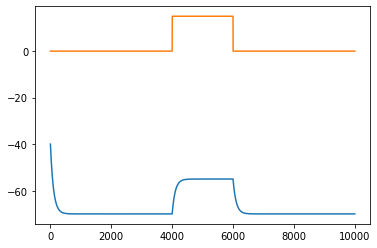

In [3]:
## toy example: a simple leaky-and-integrate-neuron

# initialize vectors for time and voltage
time = np.arange(0,10000)
voltage = np.zeros((10000,))

# initialize vector for the input current
input_current = np.zeros((10000,))
input_current[4000:6000] = 15

# Capacitance, conductance, time step
C = 1
g = 1
dt = 0.01
voltage_L = -70

# voltage at time point 0
voltage[0] = -40

# run the differential equation in time
for timepoint in time[1:]:

  voltage[timepoint] = voltage[timepoint-1] - g*(voltage[timepoint-1]-voltage_L)*dt/C + input_current[timepoint]*dt/C

# plot the result
plt.figure(121)
plt.plot(time,voltage)
plt.plot(time,input_current)


# 2. The Hodgkin and Huxley model

The main functions for the Hodgkin-Huxley model are following this Github repository: https://github.com/swharden/pyHH

The original paper describing the equations for the first time is by **Hodgkin & Huxley, J Physiol (1952)**, a highly recommended read: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/.



In [1]:
# The main functions for the Hodgkin-Huxley model are following this Github repository: https://github.com/swharden/pyHH

# define the model for the HH model neuron


class HHModel:
    """The HHModel tracks conductances of 3 channels to calculate Vm"""

    class Gate:
        """The Gate object manages a channel's kinetics and open state"""
        alpha, beta, state = 0, 0, 0

        def update(self, deltaTms):
            alphaState = self.alpha * (1-self.state)
            betaState = self.beta * self.state
            self.state += deltaTms * (alphaState - betaState)

        def setInfiniteState(self):
            self.state = self.alpha / (self.alpha + self.beta)

    ENa, EK, EKleak = 115, -12, 10.6
    gNa, gK, gKleak = 120, 36, 0.3
    m, n, h = Gate(), Gate(), Gate()
    Cm = 1

    def __init__(self, startingVoltage=0):
        self.Vm = startingVoltage
        self._UpdateGateTimeConstants(startingVoltage)
        self.m.setInfiniteState()
        self.n.setInfiniteState()
        self.n.setInfiniteState()

    def _UpdateGateTimeConstants(self, Vm):
        """Update time constants of all gates based on the given Vm"""
        self.n.alpha = .01 * ((10-Vm) / (np.exp((10-Vm)/10)-1))
        self.n.beta = .125*np.exp(-Vm/80)
        self.m.alpha = .1*((25-Vm) / (np.exp((25-Vm)/10)-1))
        self.m.beta = 4*np.exp(-Vm/18)
        self.h.alpha = .07*np.exp(-Vm/20)
        self.h.beta = 1/(np.exp((30-Vm)/10)+1)

    def _UpdateCellVoltage(self, stimulusCurrent, deltaTms):
        """calculate channel currents using the latest gate time constants"""
        self.INa = np.power(self.m.state, 3) * self.gNa * \
            self.h.state*(self.Vm-self.ENa)
        self.IK = np.power(self.n.state, 4) * self.gK * (self.Vm-self.EK)
        self.IKleak = self.gKleak * (self.Vm-self.EKleak)
        Isum = stimulusCurrent - self.INa - self.IK - self.IKleak
        self.Vm += deltaTms * Isum / self.Cm

    def _UpdateGateStates(self, deltaTms):
        """calculate new channel open states using latest Vm"""
        self.n.update(deltaTms)
        self.m.update(deltaTms)
        self.h.update(deltaTms)

    def iterate(self, stimulusCurrent, deltaTms):
        self._UpdateGateTimeConstants(self.Vm)
        self._UpdateCellVoltage(stimulusCurrent, deltaTms)
        self._UpdateGateStates(deltaTms)

In [4]:
# define the simulation to be used

class Simulation:

    def __init__(self, model):
        self.model = model
        self.CreateArrays(0, 0)
        pass

    def CreateArrays(self, pointCount, deltaTms):
        self.times = np.arange(pointCount) * deltaTms
        self.Vm = np.empty(pointCount)
        self.INa = np.empty(pointCount)
        self.IK = np.empty(pointCount)
        self.IKleak = np.empty(pointCount)
        self.StateN = np.empty(pointCount)
        self.StateM = np.empty(pointCount)
        self.StateH = np.empty(pointCount)

    def Run(self, stimulusWaveform, stepSizeMs):
        self.CreateArrays(len(stimulusWaveform), stepSizeMs)
        print(f"simulating {len(stimulusWaveform)} time points...")
        for i in range(len(stimulusWaveform)):
            self.model.iterate(stimulusWaveform[i], stepSizeMs)
            self.Vm[i] = self.model.Vm
            self.INa[i] = self.model.INa
            self.IK[i] = self.model.IK
            self.IKleak[i] = self.model.IKleak
            self.StateH[i] = self.model.h.state
            self.StateM[i] = self.model.m.state
            self.StateN[i] = self.model.n.state
        print("simulation complete")

In [5]:
# run the simulation


# customize a neuron model if desired
model = HHModel()
model.gNa = 120  # typically 120
model.gK = 36  # typically 36
model.EK = -12  # typically -12
model.ENa = 115  # typically 115

# customize a stimulus waveform
stim = np.zeros(20000)
stim[7000:13000] = 5  # add a square pulse

# simulate the model cell using the custom waveform
sim = Simulation(model)
sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)

simulating 20000 time points...
simulation complete


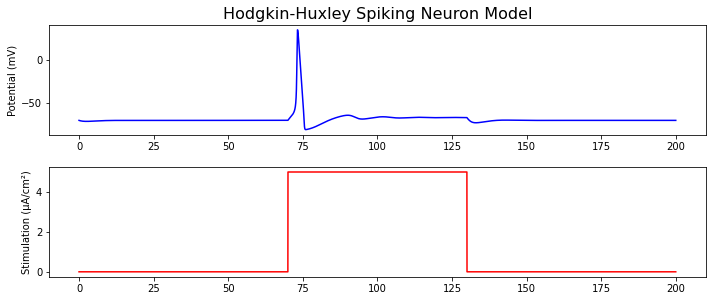

In [6]:
# plot the results with MatPlotLib
plt.figure(figsize=(10, 8))

ax1 = plt.subplot(411)
ax1.plot(sim.times, sim.Vm - 70, color='b')
ax1.set_ylabel("Potential (mV)")
ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)

ax2 = plt.subplot(412)
ax2.plot(sim.times, stim, color='r')
ax2.set_ylabel("Stimulation (µA/cm²)")

#ax3 = plt.subplot(413, sharex=ax1)
#ax3.plot(sim.times, sim.StateH, label='h')
#ax3.plot(sim.times, sim.StateM, label='m')
#ax3.plot(sim.times, sim.StateN, label='n')
#ax3.set_ylabel("Activation (frac)")
#ax3.legend()

#ax4 = plt.subplot(414, sharex=ax1)
#ax4.plot(sim.times, sim.INa, label='VGSC')
#ax4.plot(sim.times, sim.IK, label='VGKC')
#ax4.plot(sim.times, sim.IKleak, label='KLeak')
#ax4.set_ylabel("Current (µA/cm²)")
#ax4.set_xlabel("Simulation Time (milliseconds)")
#ax4.legend()

plt.tight_layout()
plt.show()

# 3. The Hodgkin and Huxley model in voltage clamp

The code is very similar to the above code for the original Hodgkin-Huxley simulation.

with the default settings, you will be able to see the active conductances when switching the holding potential from resting state to above spiking threshold: a **fast, deactivating sodium channel** component and a **slower non-deactivating potassium channel** component.

In [7]:
# define the model for the HH model neuron


class HHModel:
    """The HHModel tracks conductances of 3 channels, while keeping Vm at a fixed value"""

    class Gate:
        """The Gate object manages a channel's kinetics and open state"""
        alpha, beta, state = 0, 0, 0

        def update(self, deltaTms):
            alphaState = self.alpha * (1-self.state)
            betaState = self.beta * self.state
            self.state += deltaTms * (alphaState - betaState)

        def setInfiniteState(self):
            self.state = self.alpha / (self.alpha + self.beta)

    ENa, EK, EKleak = 115, -12, 10.6
    gNa, gK, gKleak = 120, 36, 0.3
    m, n, h = Gate(), Gate(), Gate()
    Cm = 1

    def __init__(self, startingVoltage=0):
        self.Vm = startingVoltage
        self._UpdateGateTimeConstants(startingVoltage)
        self.m.setInfiniteState()
        self.n.setInfiniteState()
        self.n.setInfiniteState()

    def _UpdateGateTimeConstants(self, Vm):
        """Update time constants of all gates based on the given Vm"""
        self.n.alpha = .01 * ((10-Vm) / (np.exp((10-Vm)/10)-1))
        self.n.beta = .125*np.exp(-Vm/80)
        self.m.alpha = .1*((25-Vm) / (np.exp((25-Vm)/10)-1))
        self.m.beta = 4*np.exp(-Vm/18)
        self.h.alpha = .07*np.exp(-Vm/20)
        self.h.beta = 1/(np.exp((30-Vm)/10)+1)

    def _UpdateCellVoltage(self, clampedVoltage, deltaTms):
        """calculate channel currents using the latest gate time constants"""
        self.INa = np.power(self.m.state, 3) * self.gNa * \
            self.h.state*(self.Vm-self.ENa)
        self.IK = np.power(self.n.state, 4) * self.gK * (self.Vm-self.EK)
        self.IKleak = self.gKleak * (self.Vm-self.EKleak)
        #Isum = stimulusCurrent - self.INa - self.IK - self.IKleak
        self.Vm = clampedVoltage

    def _UpdateGateStates(self, deltaTms):
        """calculate new channel open states using latest Vm"""
        self.n.update(deltaTms)
        self.m.update(deltaTms)
        self.h.update(deltaTms)

    def iterate(self, clampedVoltage, deltaTms):
        self._UpdateGateTimeConstants(self.Vm)
        self._UpdateCellVoltage(clampedVoltage, deltaTms)
        self._UpdateGateStates(deltaTms)

In [8]:
# define the simulation to be used

class Simulation:

    def __init__(self, model):
        self.model = model
        self.CreateArrays(0, 0)
        pass

    def CreateArrays(self, pointCount, deltaTms):
        self.times = np.arange(pointCount) * deltaTms
        self.Vm = np.empty(pointCount)
        self.INa = np.empty(pointCount)
        self.IK = np.empty(pointCount)
        self.IKleak = np.empty(pointCount)
        self.StateN = np.empty(pointCount)
        self.StateM = np.empty(pointCount)
        self.StateH = np.empty(pointCount)

    def Run(self, clampedVoltage, stepSizeMs):
        self.CreateArrays(len(clampedVoltage), stepSizeMs)
        print(f"simulating {len(clampedVoltage)} time points...")
        for i in range(len(clampedVoltage)):
            self.model.iterate(clampedVoltage[i], stepSizeMs)
            self.Vm[i] = self.model.Vm
            self.INa[i] = self.model.INa
            self.IK[i] = self.model.IK
            self.IKleak[i] = self.model.IKleak
            self.StateH[i] = self.model.h.state
            self.StateM[i] = self.model.m.state
            self.StateN[i] = self.model.n.state
        print("simulation complete")

In [9]:
# run the simulation


# customize a neuron model if desired
model = HHModel()
model.gNa = 120  # typically 120
model.gK = 36  # typically 36
model.EK = -12  # typically -12
model.ENa = 115  # typically 115

# customize a stimulus waveform
target_voltage = 0*np.ones(20000)
target_voltage[7000:13000] = 45  # add a square pulse

# simulate the model cell using the custom waveform
sim = Simulation(model)
sim.Run(clampedVoltage=target_voltage, stepSizeMs=0.01)

simulating 20000 time points...
simulation complete


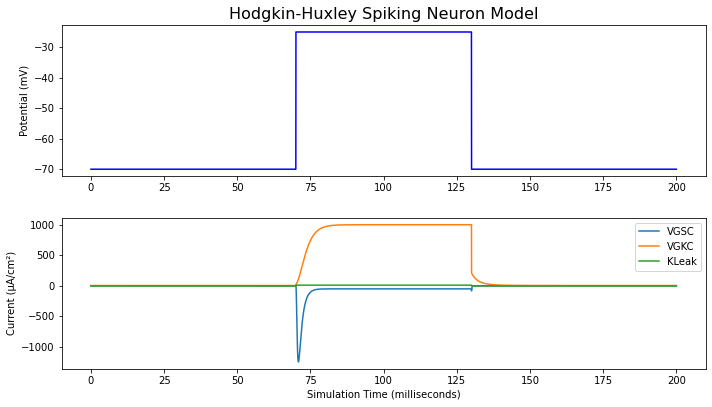

In [10]:
# plot the results with MatPlotLib
plt.figure(figsize=(10, 8))

ax1 = plt.subplot(311)
ax1.plot(sim.times, sim.Vm - 70, color='b')
ax1.set_ylabel("Potential (mV)")
ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)

#ax3 = plt.subplot(413, sharex=ax1)
#ax3.plot(sim.times, sim.StateH, label='h')
#ax3.plot(sim.times, sim.StateM, label='m')
#ax3.plot(sim.times, sim.StateN, label='n')
#ax3.set_ylabel("Activation (frac)")
#ax3.legend()

ax4 = plt.subplot(312, sharex=ax1)
ax4.plot(sim.times, sim.INa, label='VGSC')
ax4.plot(sim.times, sim.IK, label='VGKC')
ax4.plot(sim.times, sim.IKleak, label='KLeak')
ax4.set_ylabel("Current (µA/cm²)")
ax4.set_xlabel("Simulation Time (milliseconds)")
ax4.legend()

plt.tight_layout()
plt.show()